Current Python working directory: /home/ebd-marco/Documentos/Code/DocumentParsing
API Key loaded successfully!
--- IMAGE ---
type: <class 'unstructured.documents.elements.Image'>
metadata keys: dict_keys(['detection_class_prob', 'coordinates', 'links', 'last_modified', '_known_field_names', 'filetype', 'languages', 'page_number', 'image_path'])
image_base64: False
image path: ./images/figure-1-1.jpg
Image found but image_base64 is None.
--- IMAGE ---
type: <class 'unstructured.documents.elements.Image'>
metadata keys: dict_keys(['coordinates', 'links', 'last_modified', '_known_field_names', 'filetype', 'languages', 'page_number', 'image_path'])
image_base64: False
image path: ./images/figure-1-2.jpg
Image found but image_base64 is None.
--- IMAGE ---
type: <class 'unstructured.documents.elements.Image'>
metadata keys: dict_keys(['coordinates', 'links', 'last_modified', '_known_field_names', 'filetype', 'languages', 'page_number', 'image_path'])
image_base64: False
image path: ./images/

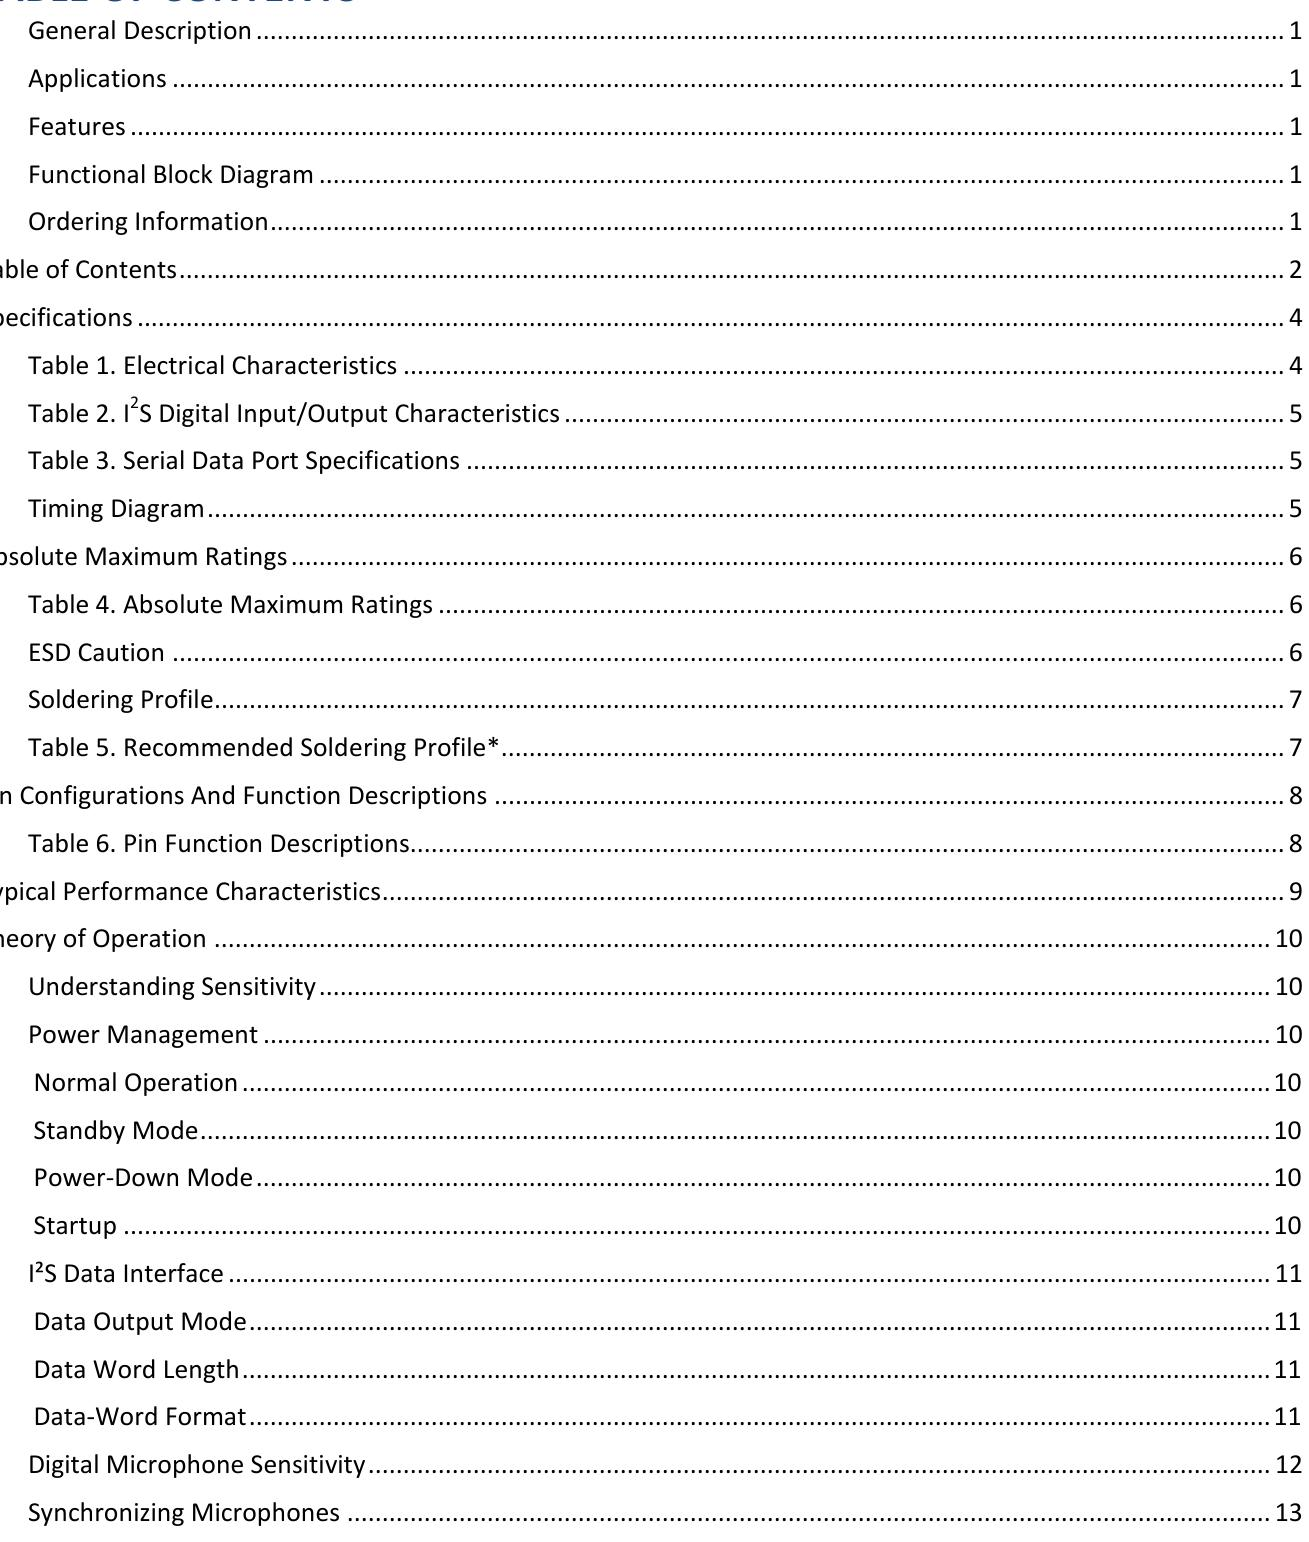

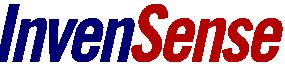

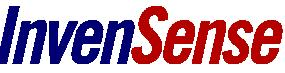

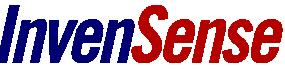

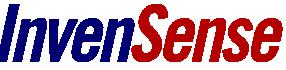

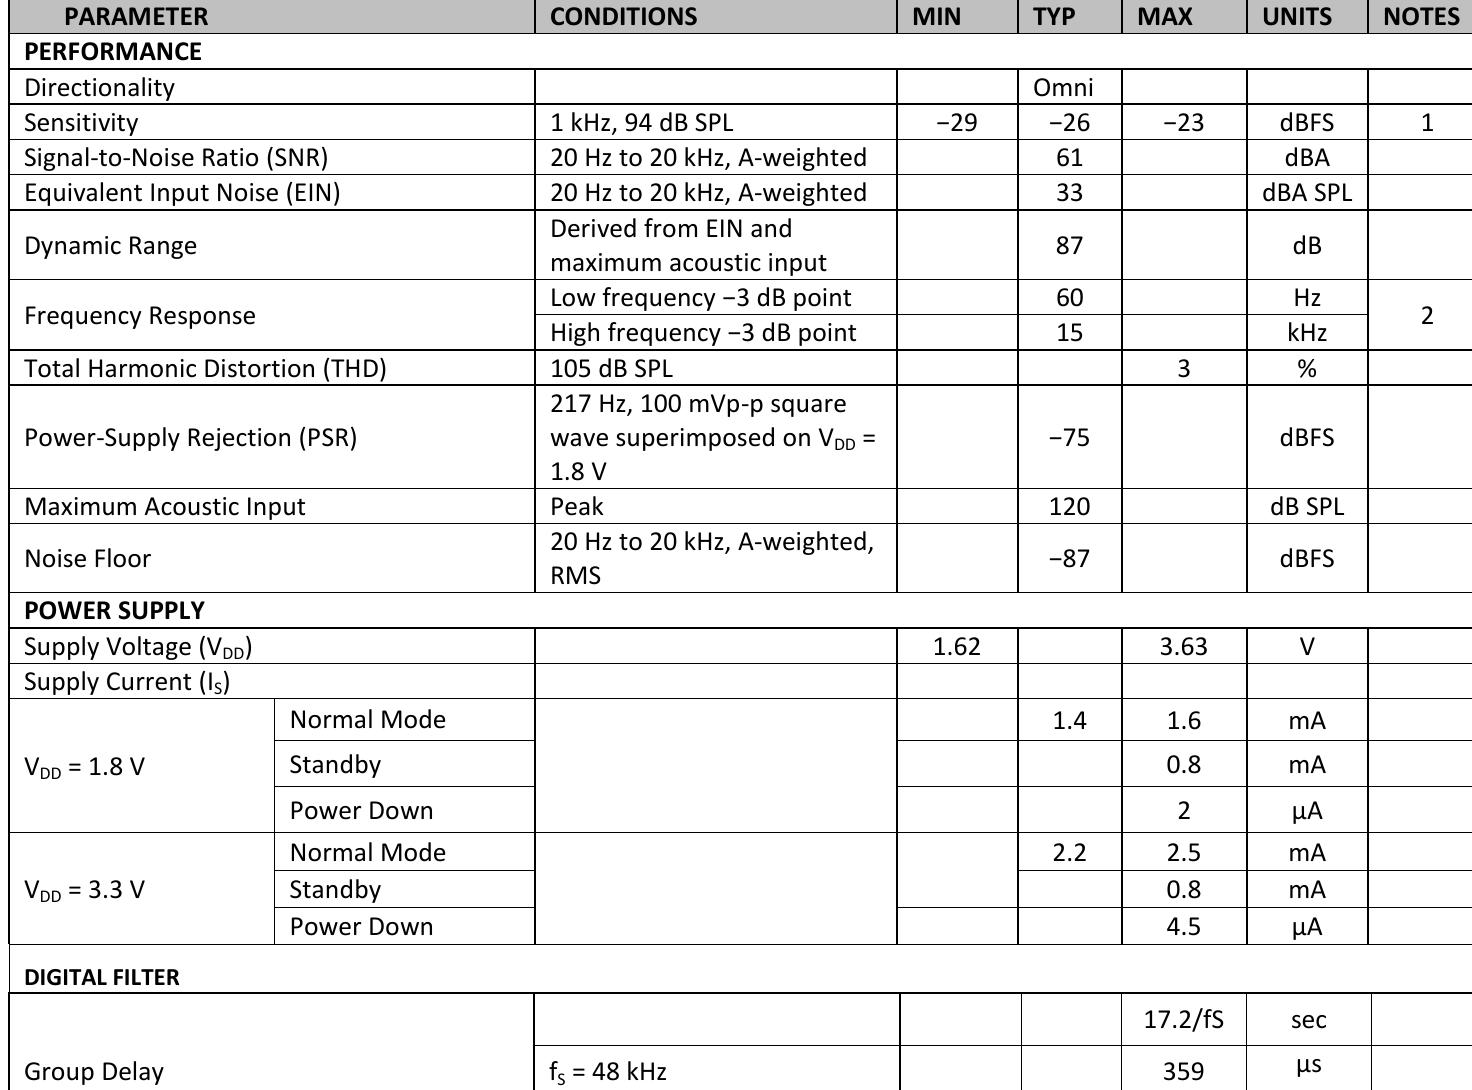

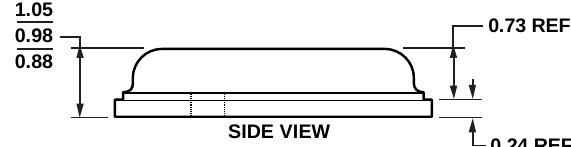

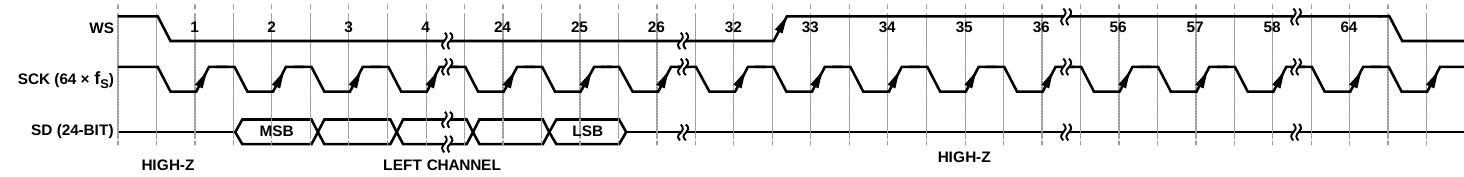

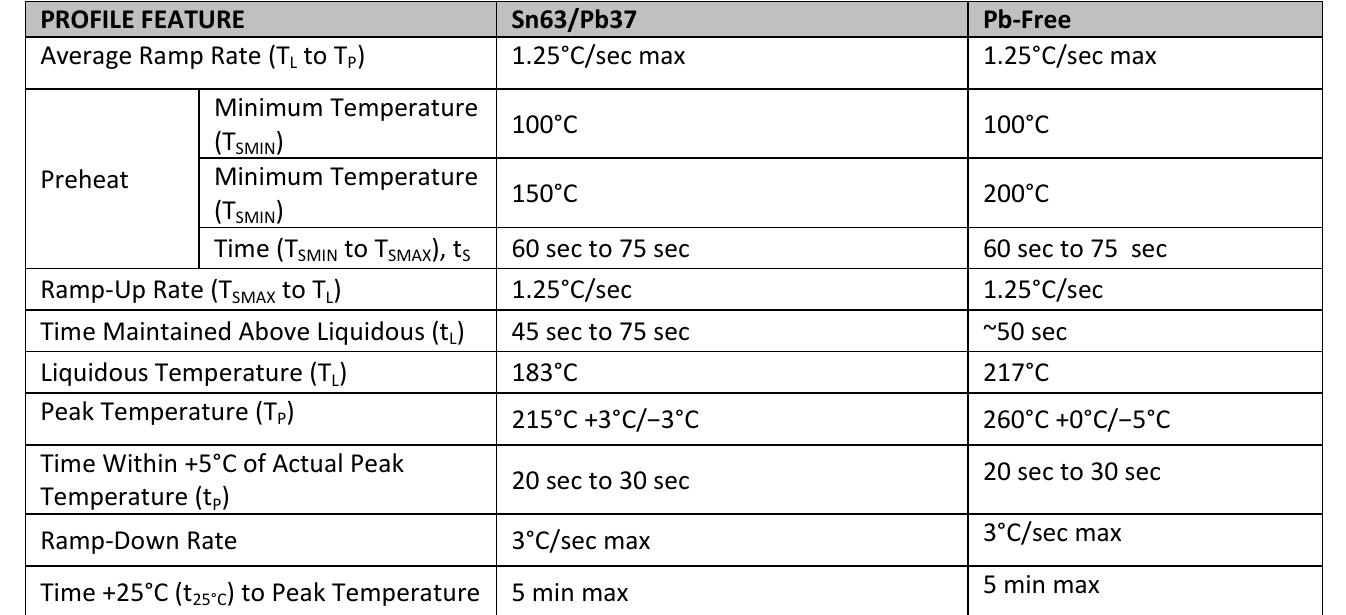

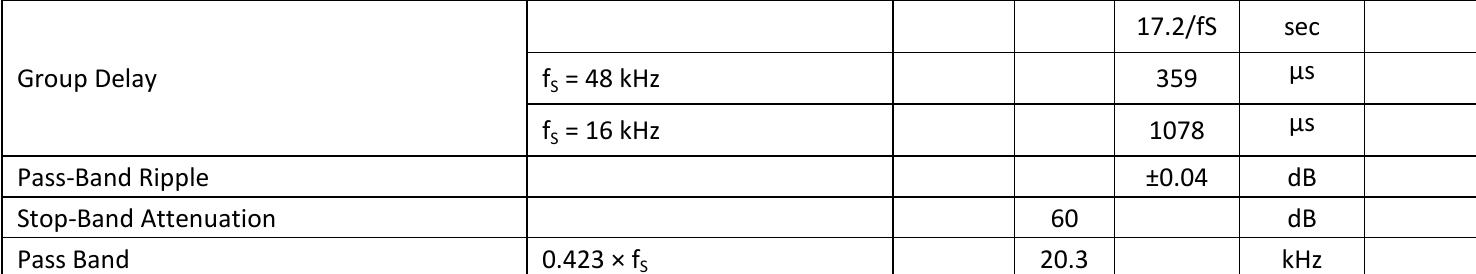

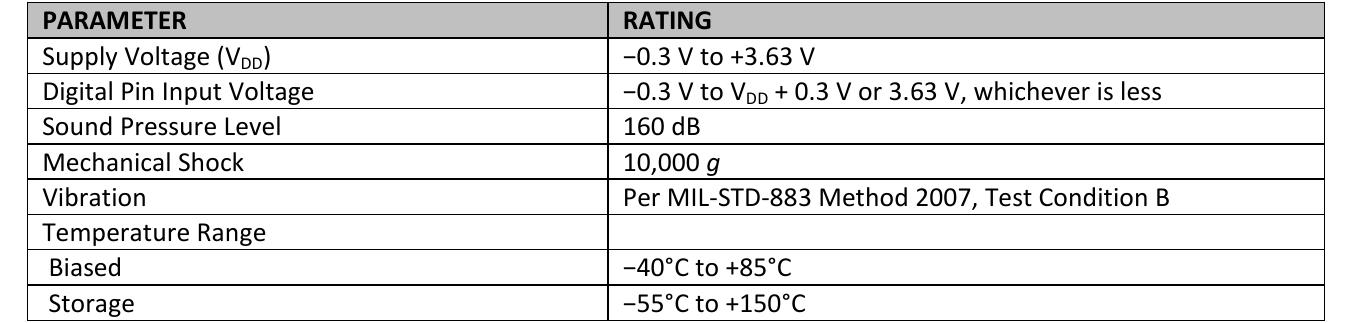

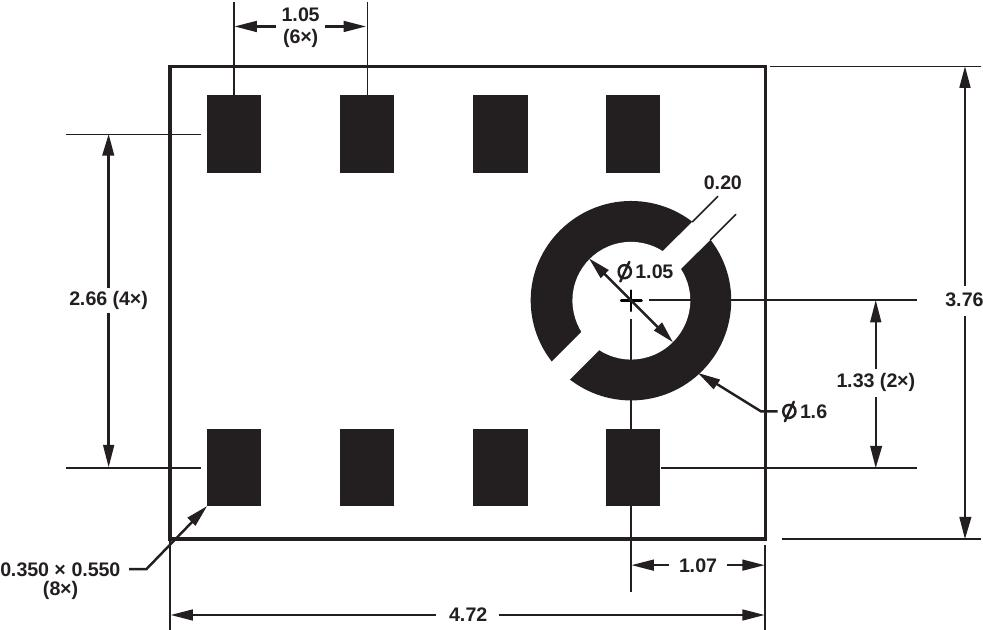

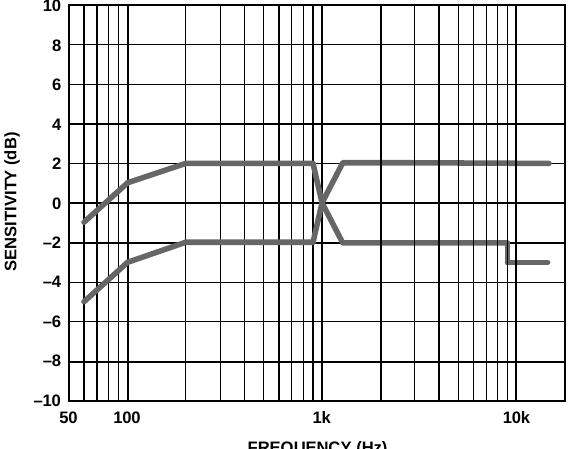

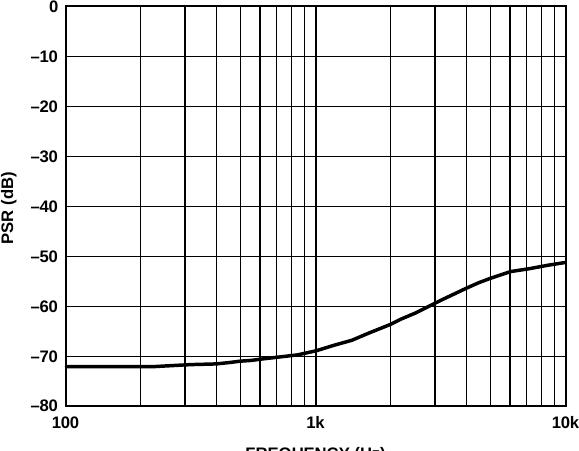

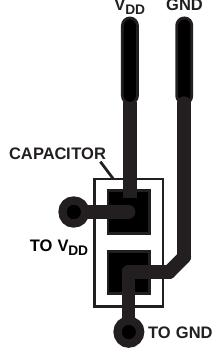

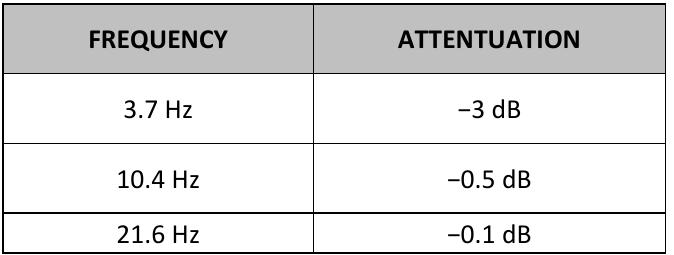

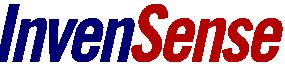

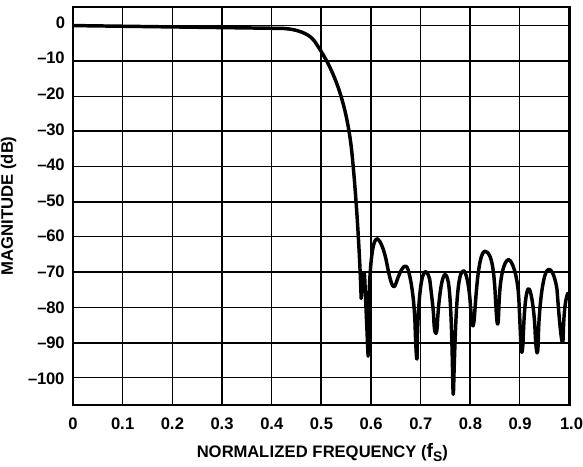

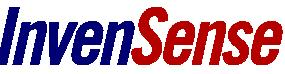

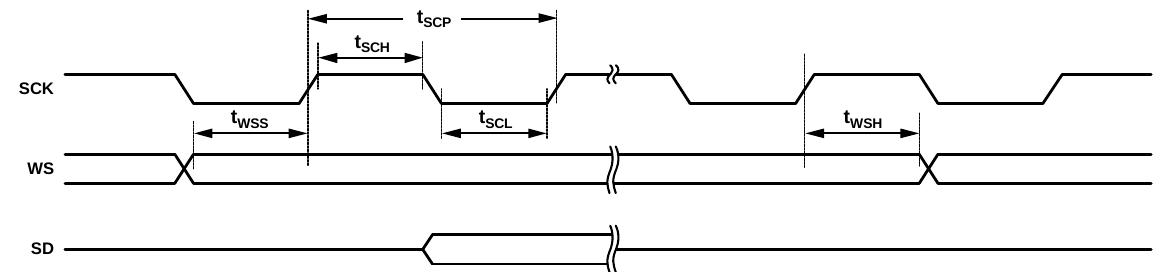

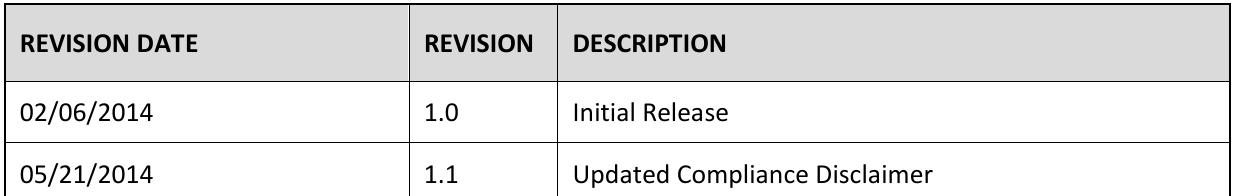

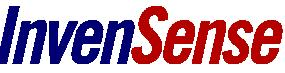

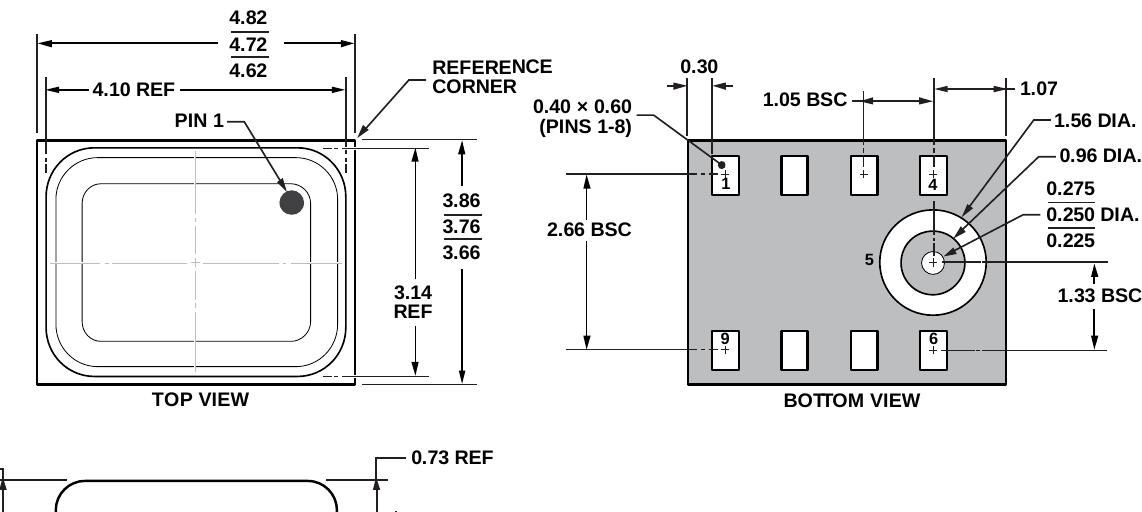

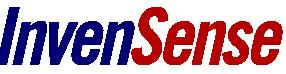

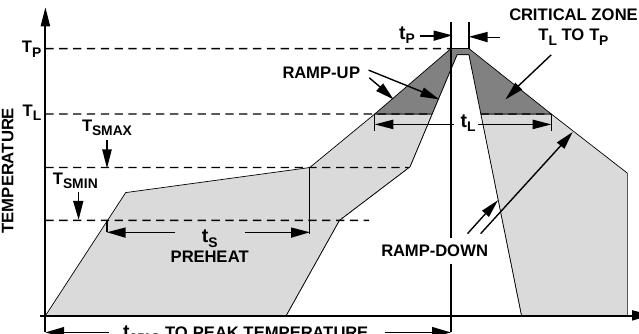

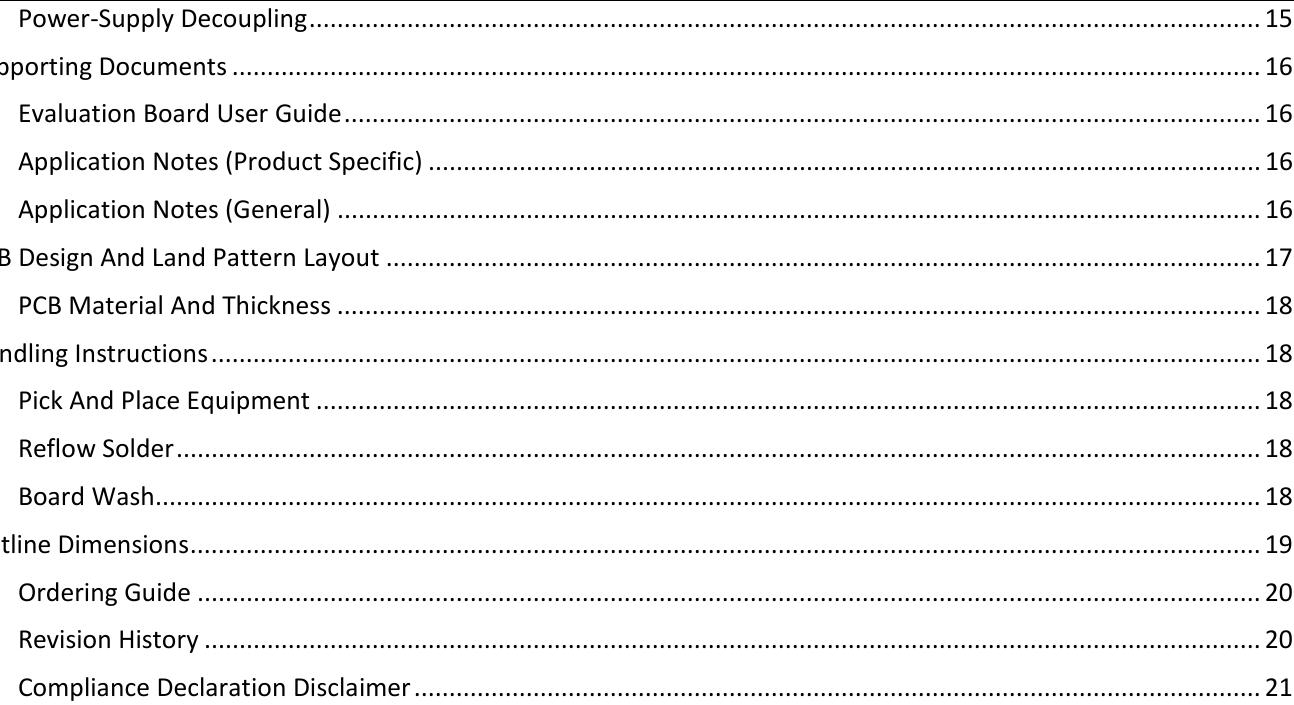

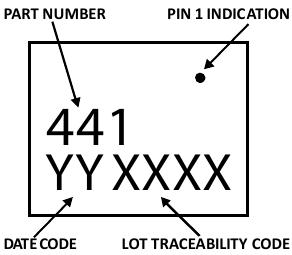

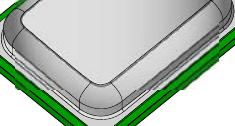

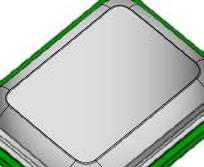

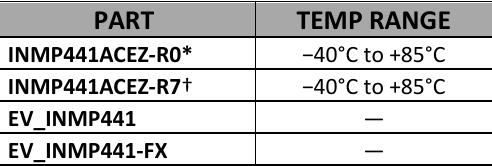

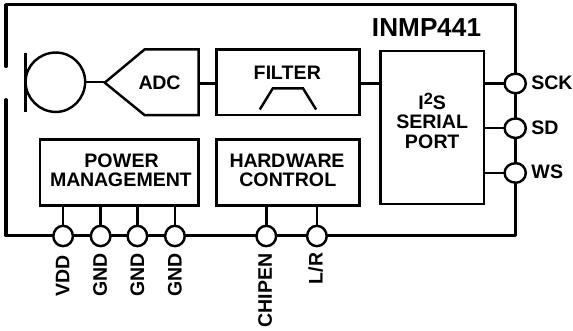

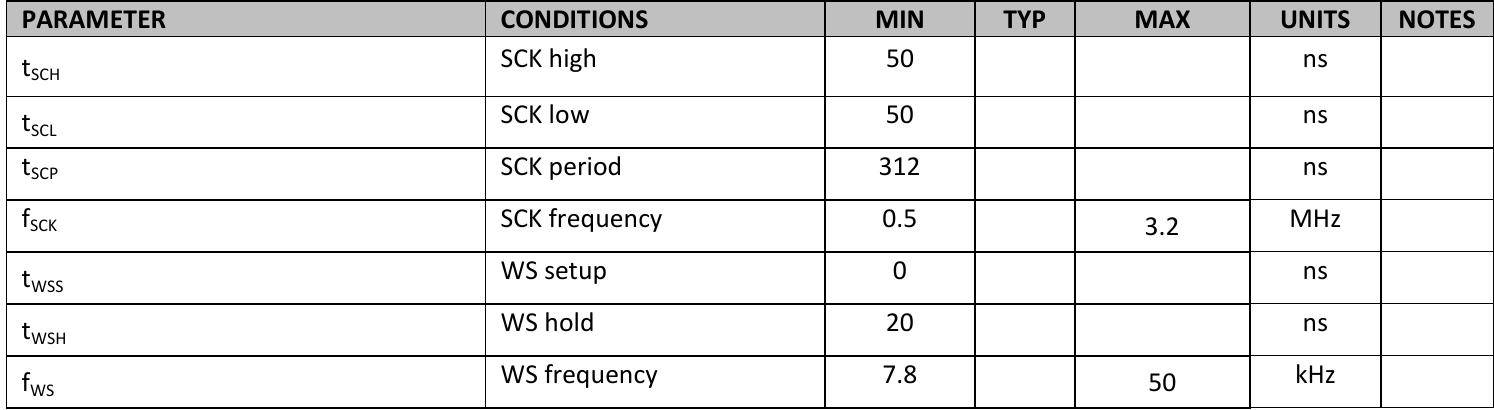

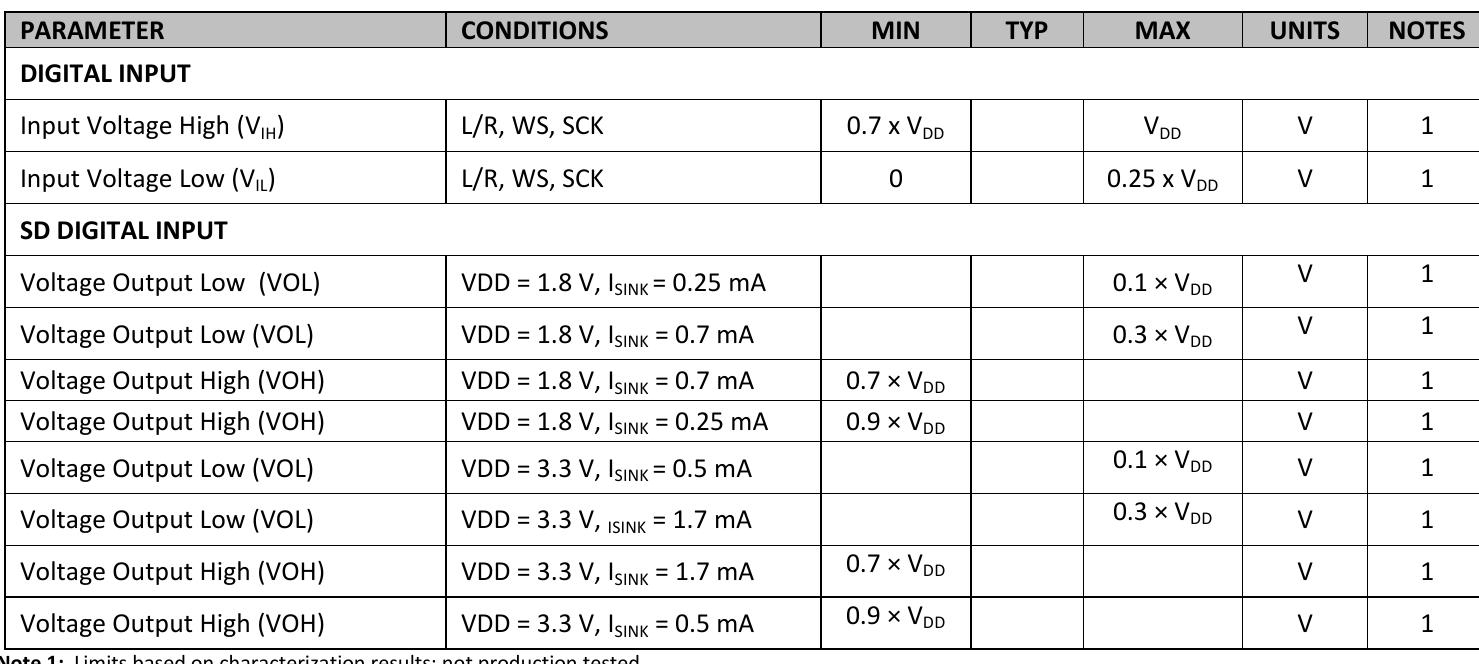

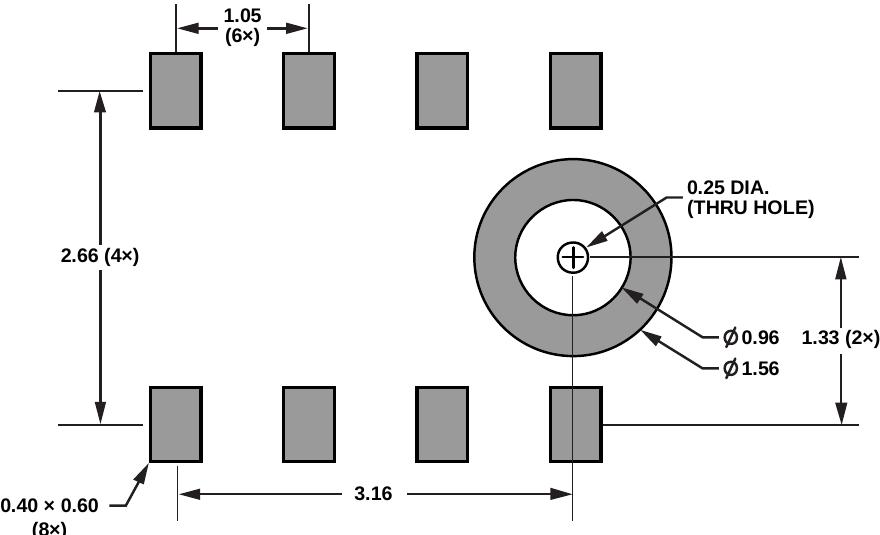

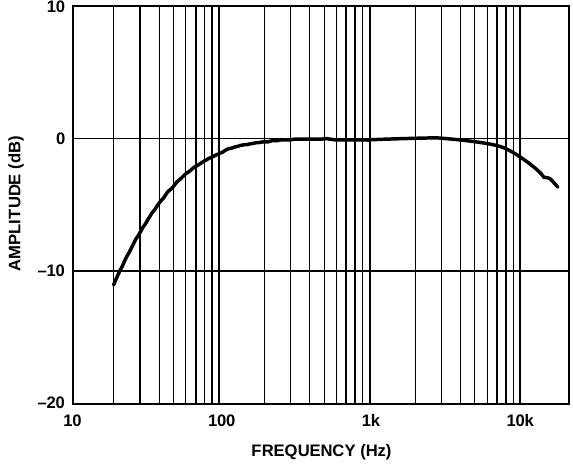

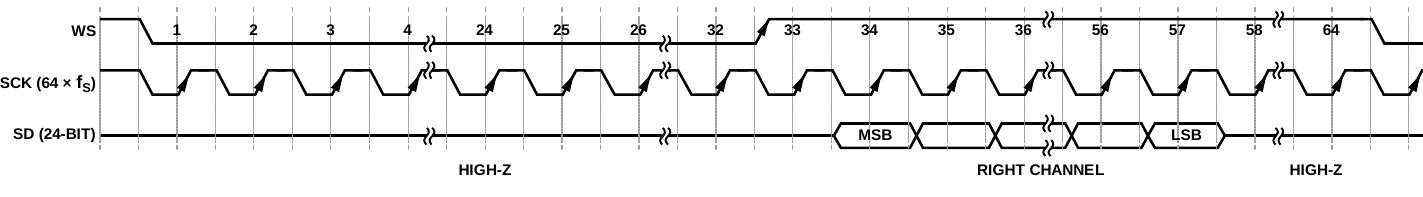

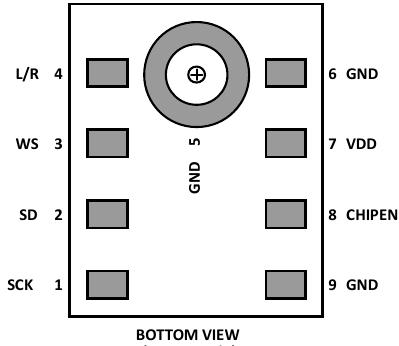

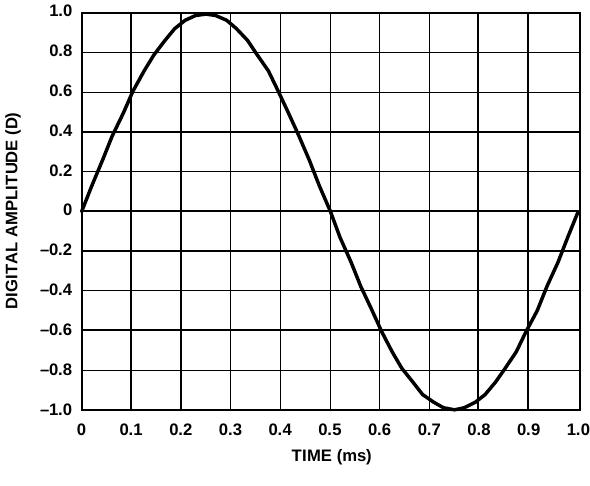

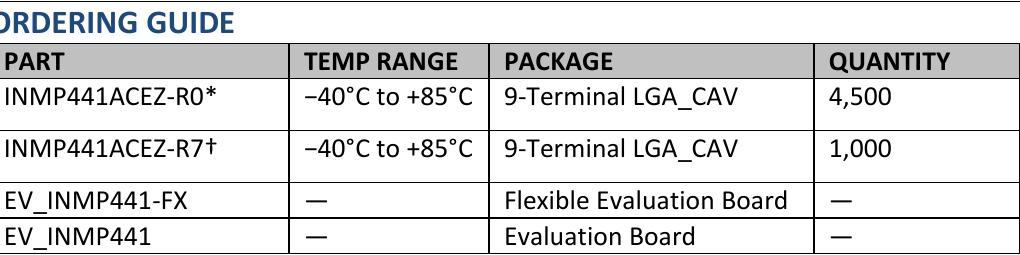

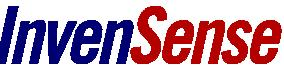

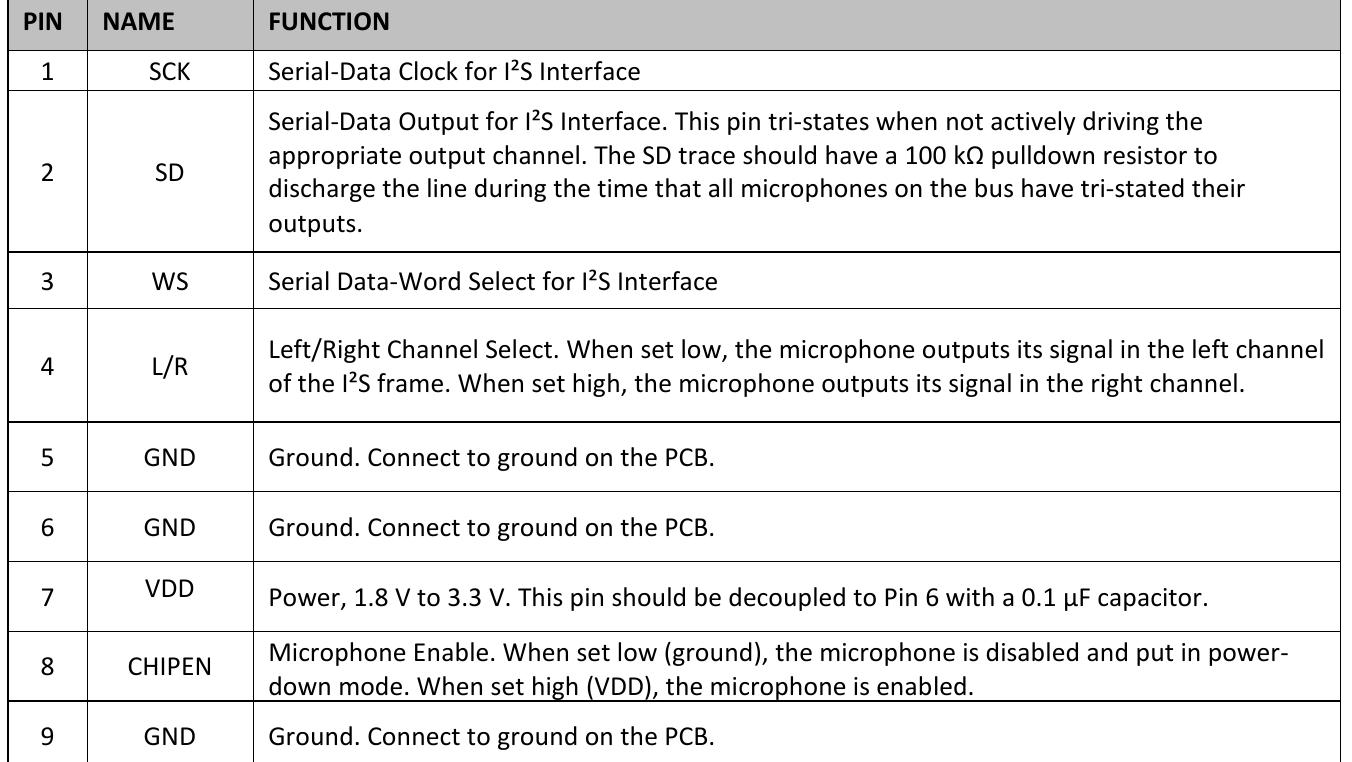

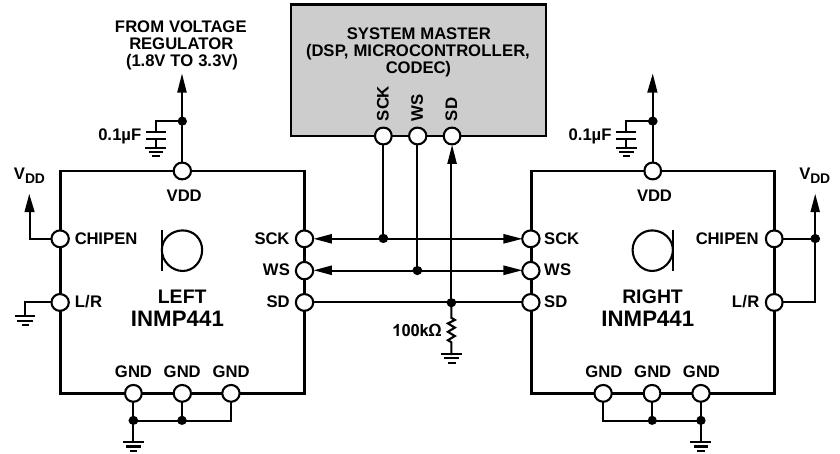

['The image appears to be a table of contents from a document, likely a technical or research paper. It includes various sections and subsections with corresponding page numbers. Here’s a detailed description:\n\n1. **General Sections:**\n   - General Description\n   - Applications\n   - Features\n   - Functional Block Diagram\n   - Ordering Information\n\n2. **Specifications:**\n   - Table 1: Electrical Characteristics\n   - Table 2: I²S Digital Input/Output Characteristics\n   - Table 3: Serial Data Port Specifications\n   - Timing Diagram\n\n3. **Absolute Maximum Ratings:**\n   - Table 4: Absolute Maximum Ratings\n   - ESD Caution\n\n4. **Soldering Profile:**\n   - Table 5: Recommended Soldering Profile\n\n5. **Pin Configurations and Function Descriptions:**\n   - Table 6: Pin Function Descriptions\n\n6. **Typical Performance Characteristics**\n\n7. **Theory of Operation:**\n   - Understanding Sensitivity\n   - Power Management\n   - Normal Operation\n   - Standby Mode\n   - Power-D

In [ ]:
import os
from dotenv import load_dotenv, find_dotenv
# find_dotenv() searches up the directory tree until it finds the .env file
from unstructured.partition.pdf import partition_pdf
import os
import base64
from IPython.display import Image, display
from langchain_openai import ChatOpenAI # Changed from langchain_groq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser


print("Current Python working directory:", os.getcwd())
load_dotenv(find_dotenv())
''
api_key = os.getenv("OPENAI_API_KEY")
file_path = os.getenv("ATTENTION_FILEPATH")

if not (api_key and file_path):
    print("Environmental variables not found.")

else:
    print("Environmental variables loaded successfully!")


chunks = partition_pdf(
    filename=file_path,                      
    infer_table_structure=True, #extract tables            
    strategy="hi_res", #mantatory to infer tables

    extract_image_block_types=["Table"],
    extract_image_block_output_type="base64",
    extract_image_block_output_dir="./images",
    extract_images_in_pdf=True,

    chunking_strategy="by_title",
    max_characters=10000,
    combine_text_under_n_chars=2000,
    new_after_n_chars=6000,
    #extract_images_in_pdf=True,
)

set([str(type(el)) for el in chunks])
chunks[3].metadata.orig_elements
len(chunks) #number of elements inside the document
tables = []
texts = []
for chunk in chunks:
    if "Table" in str(type((chunk))):
        tables.append(chunk)
    
    if "CompositeElement" in str(type(chunk)):
        texts.append(chunk)
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    print("--- IMAGE ---")
                    print(f"type: {type(el)}")
                    print(f"metadata keys: {el.metadata.__dict__.keys()}")
                    print(f"image_base64: {el.metadata.image_base64 is not None}")
                    print(f"image path: {el.metadata.image_path}")
                    image_data = el.metadata.image_base64
                    if image_data is not None:
                        images_b64.append(image_data)
                        print("Image appended.")
                    else:
                        print("Image found but image_base64 is None.")

    return images_b64

images = get_images_base64(chunks)
def get_images_base64_from_disk(image_dir="./images"):
    images_b64 = []
    for filename in os.listdir(image_dir):
        filepath = os.path.join(image_dir, filename)
        if filepath.lower().endswith((".png", ".jpg", ".jpeg")):
            with open(filepath, "rb") as img_file:
                b64 = base64.b64encode(img_file.read()).decode("utf-8")
                images_b64.append(b64)
    return images_b64

def display_base64_image(base64_code):
    for image in base64_code:
        image_data = base64.b64decode(image)
        display(Image(data=image_data))

images_b64 = get_images_base64_from_disk()
display_base64_image(images_b64)
images_b64 = get_images_base64_from_disk()
# display_base64_image(images_b64)
prompt_text = """
    You are an assistant tasked with summarizing tables and text.
    Give a concise summary of the table or text.

    Respond only with the summary, no additionnal comment.
    Do not start your message by saying "Here is a summary" or anything like that.

    Table or text chunk: {element}


"""

prompt = ChatPromptTemplate.from_template(prompt_text)

model = ChatOpenAI(temperature = 0.5, model="gpt-4o", openai_api_key=api_key)
summarize_chain = prompt | model | StrOutputParser()
text_summaries = summarize_chain.batch(texts, {"max_concurrency":3})

tables_html = [table.metadata.text_as_html for table in tables]
table_summaries = summarize_chain.batch(tables_html, {"max_concurrency":3})
text_summaries
table_summaries

prompt_template = """Describe the image in detail. For context,
                    the image is part of a research paper explaining the transformers
                    architecture. Be specific about graphs, such as bar plots."""

messages = [
    (
        "user",
        [
            {"type":"text","text":prompt_template},
            {
                "type":"image_url",
                "image_url":{"url":"data:image/jpeg;base64,{image}"},
            },
        ],
    )
]

prompt = ChatPromptTemplate.from_messages(messages)

chain = prompt | ChatOpenAI(temperature = 0.5, model="gpt-4o", openai_api_key=api_key) | StrOutputParser()

image_summaries = chain.batch(images_b64)
image_summaries


In [ ]:
import os
from dotenv import load_dotenv, find_dotenv
# find_dotenv() searches up the directory tree until it finds the .env file
from unstructured.partition.pdf import partition_pdf
import os
import base64
from IPython.display import Image, display
from langchain_openai import ChatOpenAI # Changed from langchain_groq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser


print("Current Python working directory:", os.getcwd())
load_dotenv(find_dotenv())

api_key = os.getenv("OPENAI_API_KEY")

if not api_key:
    print("OPENAI_API_KEY still not found.")
else:
    print("API Key loaded successfully!")
output_path = "./content/"
file_path = output_path + "attention.pdf"

chunks = partition_pdf(
    filename=file_path,                      
    infer_table_structure=True, #extract tables            
    strategy="hi_res", #mantatory to infer tables

    extract_image_block_types=["Table"],
    extract_image_block_output_type="base64",
    extract_image_block_output_dir="./images",
    extract_images_in_pdf=True,

    chunking_strategy="by_title",
    max_characters=10000,
    combine_text_under_n_chars=2000,
    new_after_n_chars=6000,
    #extract_images_in_pdf=True,
)

set([str(type(el)) for el in chunks])
chunks[3].metadata.orig_elements
len(chunks) #number of elements inside the document
tables = []
texts = []
for chunk in chunks:
    if "Table" in str(type((chunk))):
        tables.append(chunk)
    
    if "CompositeElement" in str(type(chunk)):
        texts.append(chunk)
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    print("--- IMAGE ---")
                    print(f"type: {type(el)}")
                    print(f"metadata keys: {el.metadata.__dict__.keys()}")
                    print(f"image_base64: {el.metadata.image_base64 is not None}")
                    print(f"image path: {el.metadata.image_path}")
                    image_data = el.metadata.image_base64
                    if image_data is not None:
                        images_b64.append(image_data)
                        print("Image appended.")
                    else:
                        print("Image found but image_base64 is None.")

    return images_b64

images = get_images_base64(chunks)
def get_images_base64_from_disk(image_dir="./images"):
    images_b64 = []
    for filename in os.listdir(image_dir):
        filepath = os.path.join(image_dir, filename)
        if filepath.lower().endswith((".png", ".jpg", ".jpeg")):
            with open(filepath, "rb") as img_file:
                b64 = base64.b64encode(img_file.read()).decode("utf-8")
                images_b64.append(b64)
    return images_b64

def display_base64_image(base64_code):
    for image in base64_code:
        image_data = base64.b64decode(image)
        display(Image(data=image_data))

images_b64 = get_images_base64_from_disk()
display_base64_image(images_b64)
images_b64 = get_images_base64_from_disk()
# display_base64_image(images_b64)
prompt_text = """
    You are an assistant tasked with summarizing tables and text.
    Give a concise summary of the table or text.

    Respond only with the summary, no additionnal comment.
    Do not start your message by saying "Here is a summary" or anything like that.

    Table or text chunk: {element}


"""

prompt = ChatPromptTemplate.from_template(prompt_text)

model = ChatOpenAI(temperature = 0.5, model="gpt-4o", openai_api_key=api_key)
summarize_chain = prompt | model | StrOutputParser()
text_summaries = summarize_chain.batch(texts, {"max_concurrency":3})

tables_html = [table.metadata.text_as_html for table in tables]
table_summaries = summarize_chain.batch(tables_html, {"max_concurrency":3})
text_summaries
table_summaries

prompt_template = """Describe the image in detail. For context,
                    the image is part of a research paper explaining the transformers
                    architecture. Be specific about graphs, such as bar plots."""

messages = [
    (
        "user",
        [
            {"type":"text","text":prompt_template},
            {
                "type":"image_url",
                "image_url":{"url":"data:image/jpeg;base64,{image}"},
            },
        ],
    )
]

prompt = ChatPromptTemplate.from_messages(messages)

chain = prompt | ChatOpenAI(temperature = 0.5, model="gpt-4o", openai_api_key=api_key) | StrOutputParser()

image_summaries = chain.batch(images_b64)
image_summaries
